In [1]:
%pip install optuna edge-ml tsflex plotly tsfresh torch timeout_decorator

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pickle
import pandas as pd
project=pickle.load(open("data_snapshot/project_css25.pkl","rb"))

In [3]:
sensor="deviceorientation"

In [4]:
df=pd.concat([d.data.iloc[40:-40].dropna().assign(**d.metaData) for d  in project.datasets if (d.name == sensor and d.data.shape[0]>0) and d.timeSeries[0].end-d.timeSeries[0].start>10000] )
df.set_index(["participantId","time"], inplace=True)
df=df[df.activity!="testing"]

In [5]:
ts_cols=[col for col in df.columns if col not in ["activity","mobile","browser"] ]
ts_cols

['alpha', 'beta', 'gamma']

In [6]:
from tsflex.features import FeatureCollection, FuncWrapper, MultipleFeatureDescriptors
from tsflex.processing import SeriesProcessor
from tsflex.features.integrations import tsfresh_settings_wrapper
from tsfresh.feature_extraction import MinimalFCParameters

import numpy as np

 

# Common statistical + signal features approximating TSFRESH minimal set
tsfresh_minimal_funcs =   [
        FuncWrapper(np.sum, output_names="sum"),
        FuncWrapper(np.median, output_names="median"),
        FuncWrapper(np.mean, output_names="mean"),
        FuncWrapper(lambda x: len(x), output_names="length"),
        FuncWrapper(np.std, output_names="std_dev"),
        FuncWrapper(np.var, output_names="var"),
        FuncWrapper(lambda x: np.sqrt(np.mean(np.square(x))), output_names="root_mean_square"),
        FuncWrapper(lambda x: np.max(x) if len(x) > 0 else np.nan, output_names="max"),
        FuncWrapper(lambda x: np.max(np.abs(x)) if len(x) > 0 else np.nan, output_names="abs_max"),
        FuncWrapper(lambda x: np.min(x) if len(x) > 0 else np.nan, output_names="min"),
    ]
#tsfresh_minimal_funcs=tsfresh_settings_wrapper(MinimalFCParameters())

window_ms=1000

fc = FeatureCollection( feature_descriptors = [ MultipleFeatureDescriptors(  
        series_names=ts_cols , 
        functions=tsfresh_minimal_funcs,
        windows=[f"{window_ms}ms"],
        strides=[f"{int(window_ms/10)}ms"]
        )
        ] )


In [7]:
%env PYTHONWARNINGS=ignore

import warnings

from joblib import Parallel, delayed
from tqdm.notebook import tqdm




# Prepare the groups
grouped = df.reset_index().set_index("time").groupby(["participantId", "activity"])

# Optional: Convert to a list to avoid multiple iterations over the generator
grouped_items = list(grouped)

# Define your processing function
def process_group(pid, group):
    warnings.filterwarnings('ignore')
    feats=pd.concat(fc.calculate(group, n_jobs=1),axis=1)
    #display(feats)
    feats["participantId"]=pid[0]
    feats["activity"] = pid[1]
    return feats.dropna().reset_index().set_index(["participantId","time"])

# Wrap with tqdm for progress
results = Parallel(n_jobs=-1)(
    delayed(process_group)(pid, group)
    for pid, group in tqdm(grouped_items, desc="Processing groups")
)


df1=pd.concat(results, axis=0)
 #   display(all_feats)

df1

env: PYTHONWARNINGS=ignore


Processing groups:   0%|          | 0/24 [00:00<?, ?it/s]

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:24.881       2431.700195            83.800003   
              2025-06-03 12:01:24.981       2516.600586            83.900002   
              2025-06-03 12:01:25.081       2433.200195            83.900002   
              2025-06-03 12:01:25.181       2349.600098            83.900002   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:29.060        834.509949            12.525000   
              2025-06-23 19:10:29.160        824.580017            12.525000   
              2025-06-23 19:10:29.260        805.789978            12.525000   
              2025-06-23 19:10:29.360        782.669983            12.445000   
              2025-06-23 19:10:29.460        761.979980            11.900000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:24.881          83.851730                   29   
              2025-06-03 12:01:24.981          83.886688                   30   
              2025-06-03 12:01:25.081          83.903458                   29   
              2025-06-03 12:01:25.181          83.914291                   28   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:29.060          13.908499                   60   
              2025-06-23 19:10:29.160          13.743000                   60   
              2025-06-23 19:10:29.260          13.429833                   60   
              2025-06-23 19:10:29.360          13.044499                   60   
              2025-06-23 19:10:29.460          12.491475                   61   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:24.881              0.127633          0.016290   
              2025-06-03 12:01:24.981              0.145449          0.021155   
              2025-06-03 12:01:25.081              0.137672          0.018954   
              2025-06-03 12:01:25.181              0.132864          0.017653   
...                                                     ...               ...   
1f683         2025-06-23 19:10:29.060              2.439942          5.953319   
              2025-06-23 19:10:29.160              2.343845          5.493608   
              2025-06-23 19:10:29.260              2.063793          4.259242   
              2025-06-23 19:10:29.360              1.648176          2.716485   
              2025-06-23 19:10:29.460              1.103872          1.218534   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:24.881                      83.851822   
              2025-06-03 12:01:24.981                      83.886795   
              2025-06-03 12:01:25.081                      83.903564   
              2025-06-03 12:01:25.181                      83.914391   
...                                                              ...   
1f683         2025-06-23 19:10:29.060                      14.120895   
              2025-06-23 19:10:29.160                      13.941437   
              2025-06-23 19:10:29.260                      13.587481   
              2025-06-23 19:10:29.360                      13.148212   
              2025-06-23 1

In [8]:
tsfresh_minimal_funcs

[FuncWrapper(sum, ['sum'], {}),
 FuncWrapper(median, ['median'], {}),
 FuncWrapper(mean, ['mean'], {}),
 FuncWrapper(<lambda>, ['length'], {}),
 FuncWrapper(std, ['std_dev'], {}),
 FuncWrapper(var, ['var'], {}),
 FuncWrapper(<lambda>, ['root_mean_square'], {}),
 FuncWrapper(<lambda>, ['max'], {}),
 FuncWrapper(<lambda>, ['abs_max'], {}),
 FuncWrapper(<lambda>, ['min'], {})]

In [9]:
df1

alpha__sum__w=1s  alpha__median__w=1s  \
participantId time                                                             
10d83         2025-06-03 12:01:24.781       2515.500000            83.850006   
              2025-06-03 12:01:24.881       2431.700195            83.800003   
              2025-06-03 12:01:24.981       2516.600586            83.900002   
              2025-06-03 12:01:25.081       2433.200195            83.900002   
              2025-06-03 12:01:25.181       2349.600098            83.900002   
...                                                 ...                  ...   
1f683         2025-06-23 19:10:29.060        834.509949            12.525000   
              2025-06-23 19:10:29.160        824.580017            12.525000   
              2025-06-23 19:10:29.260        805.789978            12.525000   
              2025-06-23 19:10:29.360        782.669983            12.445000   
              2025-06-23 19:10:29.460        761.979980            11.900000   

                                       alpha__mean__w=1s  alpha__length__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781          83.849998                   30   
              2025-06-03 12:01:24.881          83.851730                   29   
              2025-06-03 12:01:24.981          83.886688                   30   
              2025-06-03 12:01:25.081          83.903458                   29   
              2025-06-03 12:01:25.181          83.914291                   28   
...                                                  ...                  ...   
1f683         2025-06-23 19:10:29.060          13.908499                   60   
              2025-06-23 19:10:29.160          13.743000                   60   
              2025-06-23 19:10:29.260          13.429833                   60   
              2025-06-23 19:10:29.360          13.044499                   60   
              2025-06-23 19:10:29.460          12.491475                   61   

                                       alpha__std_dev__w=1s  alpha__var__w=1s  \
participantId time                                                              
10d83         2025-06-03 12:01:24.781              0.117615          0.013833   
              2025-06-03 12:01:24.881              0.127633          0.016290   
              2025-06-03 12:01:24.981              0.145449          0.021155   
              2025-06-03 12:01:25.081              0.137672          0.018954   
              2025-06-03 12:01:25.181              0.132864          0.017653   
...                                                     ...               ...   
1f683         2025-06-23 19:10:29.060              2.439942          5.953319   
              2025-06-23 19:10:29.160              2.343845          5.493608   
              2025-06-23 19:10:29.260              2.063793          4.259242   
              2025-06-23 19:10:29.360              1.648176          2.716485   
              2025-06-23 19:10:29.460              1.103872          1.218534   

                                       alpha__root_mean_square__w=1s  \
participantId time                                                     
10d83         2025-06-03 12:01:24.781                      83.850075   
              2025-06-03 12:01:24.881                      83.851822   
              2025-06-03 12:01:24.981                      83.886795   
              2025-06-03 12:01:25.081                      83.903564   
              2025-06-03 12:01:25.181                      83.914391   
...                                                              ...   
1f683         2025-06-23 19:10:29.060                      14.120895   
              2025-06-23 19:10:29.160                      13.941437   
              2025-06-23 19:10:29.260                      13.587481   
              2025-06-23 19:10:29.360                      13.148212   
              2025-06-23 1

In [10]:
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(n_splits=1, test_size=0.1, random_state=42)


for train_idx, test_idx in splitter.split(y=df1.activity, X=df1.drop(columns=["activity"]), groups=df1.reset_index().participantId):
    train, test = df1.iloc[train_idx], df1.iloc[test_idx]

In [11]:
test.reset_index().participantId.unique()

array(['10d83', '11416'], dtype=object)

In [12]:
train.reset_index().participantId.unique()

array(['12358', '12f77', '150c9', '152a7', '15b85', '18582', '191d4',
       '19ee7', '1a045', '1b682', '1b728', '1b949', '1dd54', '1e570',
       '1f683'], dtype=object)

In [13]:
%pip install imblearn

Note: you may need to restart the kernel to use updated packages.


In [14]:
train.activity.factorize()

(array([0, 0, 0, ..., 1, 1, 1], shape=(6172,)),
 Index(['walking', 'sitting', 'standing'], dtype='object'))

In [15]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GroupKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
import optuna

X,y,groups= train.drop(columns=["activity"]), train.activity, train.reset_index().participantId

cv = GroupKFold(n_splits=5)


def objective(trial):
    clf=Pipeline([ ("sample", SMOTE()) , ("clf",DecisionTreeClassifier(max_depth=trial.suggest_int('max_depth',1,20))),])
    return cross_val_score(clf,X,y,cv=cv, groups=groups, scoring="f1_macro").mean()

study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
study.optimize(objective,n_trials=1)

/tmp/ipykernel_40847/3960902939.py:16: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
[I 2025-07-12 23:56:35,348] A new study created in memory with name: no-name-27faf65d-9b20-4d4e-9455-25a4ae7a07b1
[I 2025-07-12 23:56:36,364] Trial 0 finished with value: 0.5109528038173151 and parameters: {'max_depth': 9}. Best is trial 0 with value: 0.5109528038173151.


In [16]:
cv = GroupKFold(n_splits=5)
splits=list(cv.split(X, y, groups))
splits[0]

(array([   0,    1,    2, ..., 6169, 6170, 6171], shape=(4898,)),
 array([ 406,  407,  408, ..., 5029, 5030, 5031], shape=(1274,)))

In [17]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import (
    LogisticRegression, RidgeClassifier, SGDClassifier, PassiveAggressiveClassifier, Perceptron
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.utils import all_estimators
import timeout_decorator
import random

X,y,groups= train.drop(columns=["activity"]), train.activity, train.reset_index().participantId
cv = GroupKFold(n_splits=5)
splits=list(cv.split(X, y, groups))



#@timeout_decorator.timeout(30, timeout_exception=optuna.TrialPruned, use_signals=True)
def cross_val_score_to(clf,X,y,cv=None, groups=None, scoring=None):
    cross_val_score(clf,X,y,cv=cv, groups=groups, scoring=scoring)

clfs={
        "lr": LogisticRegression,
        "ridge": RidgeClassifier,
        "sgd": SGDClassifier,
        "lsvc": LinearSVC,
        "svc": SVC,
        "pac": PassiveAggressiveClassifier,
        "perc": Perceptron,
        "dt": DecisionTreeClassifier,
        "et": ExtraTreeClassifier,
        "rf":RandomForestClassifier,
        "etrees":ExtraTreesClassifier,
     }

def objective(trial):
    from sklearn.datasets import load_iris  # replace with your data

    model_name = trial.suggest_categorical("classifier", clfs.keys())

    if model_name == "lr":
        clf = LogisticRegression(
            C=trial.suggest_float("lr_C", 1e-3, 100, log=True),
            solver="liblinear"
        )
    elif model_name == "ridge":
        clf = RidgeClassifier(
            alpha=trial.suggest_float("ridge_alpha", 1e-3, 10, log=True)
        )
    elif model_name == "sgd":
        clf = SGDClassifier(
            loss=trial.suggest_categorical("sgd_loss", ["hinge", "log_loss"]),
            alpha=trial.suggest_float("sgd_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000,
            tol=1e-3
        )
    elif model_name == "lsvc":
        clf = LinearSVC(
            C=trial.suggest_float("lsvc_C", 1e-3, 100, log=True),
            max_iter=1000
        )
    elif model_name == "svc":
        clf = SVC(
            C=trial.suggest_float("svc_C", 1e-3, 100, log=True),
            kernel=trial.suggest_categorical("svc_kernel", ["linear", "rbf"]),
            gamma=trial.suggest_categorical("svc_gamma", ["scale", "auto"])
        )
    elif model_name == "pac":
        clf = PassiveAggressiveClassifier(
            C=trial.suggest_float("pac_C", 1e-3, 10, log=True)
        )
    elif model_name == "perc":
        clf = Perceptron(
            alpha=trial.suggest_float("perc_alpha", 1e-5, 1e-1, log=True),
            max_iter=1000
        )
    elif model_name == "dt":
        clf = DecisionTreeClassifier(
            max_depth=trial.suggest_int("dt_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("dt_min_samples_split", 2, 10)
        )
    elif model_name == "et":
        clf = ExtraTreeClassifier(
            max_depth=trial.suggest_int("et_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("et_min_samples_split", 2, 10)
        )
    elif model_name == "rf":
        clf = RandomForestClassifier(
            n_estimators=trial.suggest_int("rf_n_estimators", 50, 200),
            max_depth=trial.suggest_int("rf_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("rf_min_samples_split", 2, 10)
        )
    elif model_name == "etrees":
        clf = ExtraTreesClassifier(
            n_estimators=trial.suggest_int("etrees_n_estimators", 50, 200),
            max_depth=trial.suggest_int("etrees_max_depth", 2, 20),
            min_samples_split=trial.suggest_int("etrees_min_samples_split", 2, 10)
        )
    else:
        raise ValueError(f"Unsupported model: {model_name}")

    # Pipeline with scaling (important for linear models and SVMs)
    pipeline = make_pipeline(RobustScaler(), clf)
    #return cross_val_score(clf,X,y,cv=cv, groups=groups, scoring="f1_macro").mean()
    train_idx, test_idx = random.choice(splits)
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])

    # Predict and evaluate
    y_pred = pipeline.predict(X.iloc[test_idx])
    return f1_score(y.iloc[test_idx], y_pred, average='macro')

study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
study.optimize(objective,n_trials=1000,n_jobs=-1, timeout=60, show_progress_bar=True)

/tmp/ipykernel_40847/2964493964.py:116: ExperimentalWarning: GPSampler is experimental (supported from v3.6.0). The interface can change in the future.
  study= optuna.study.create_study(sampler= optuna.samplers.GPSampler(), direction="maximize")
[I 2025-07-12 23:56:36,380] A new study created in memory with name: no-name-f86b46f6-626d-4e2b-96bb-11946912997b


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-12 23:56:37,225] Trial 4 finished with value: 0.31561641265810136 and parameters: {'classifier': 'dt', 'dt_max_depth': 5, 'dt_min_samples_split': 6}. Best is trial 4 with value: 0.31561641265810136.
[I 2025-07-12 23:56:37,257] Trial 6 finished with value: 0.2252881688142788 and parameters: {'classifier': 'dt', 'dt_max_depth': 19, 'dt_min_samples_split': 6}. Best is trial 4 with value: 0.31561641265810136.


/opt/conda/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[I 2025-07-12 23:56:37,346] Trial 1 finished with value: 0.394351577981883 and parameters: {'classifier': 'sgd', 'sgd_loss': 'hinge', 'sgd_alpha': 0.0032534692728562447}. Best is trial 1 with value: 0.394351577981883.
[I 2025-07-12 23:56:37,436] Trial 13 finished with value: 0.5123493173493173 and parameters: {'classifier': 'et', 'et_max_depth': 12, 'et_min_samples_split': 5}. Best is trial 13 with value: 0.5123493173493173.
[I 2025-07-12 23:56:37,456] Trial 14 finished with value: 0.2392367322599881 and parameters: {'classifier': 'dt', 'dt_max_depth': 16, 'dt_min_samples_split': 4}. Best is trial 13 with value: 0.5123493173493173.
[I 2025-07-12 23:56:37,527] Trial 16 finished with value: 0.4070902070902071 and parameters: {'classifier': 'perc', 'perc_alpha': 1.5509202758065115e-05}. Best is trial 13 with value: 0.5123493173493173.
[I 2025-07-12 23:56:37,543] Trial 26 finished with value: 0.5531081731947821 and parameters: {'classifier': 'lr', 'lr_C': 0.0508248018909536}. Best is trial

In [18]:
study.best_params

{'classifier': 'rf',
 'rf_n_estimators': 134,
 'rf_max_depth': 9,
 'rf_min_samples_split': 6}

In [19]:
params={k.removeprefix(study.best_params["classifier"]+"_"): v for k, v in study.best_params.items()}
params.pop("classifier", None) 
clf=clfs[study.best_params['classifier']](**params)
clf

RandomForestClassifier(max_depth=9, min_samples_split=6, n_estimators=134)

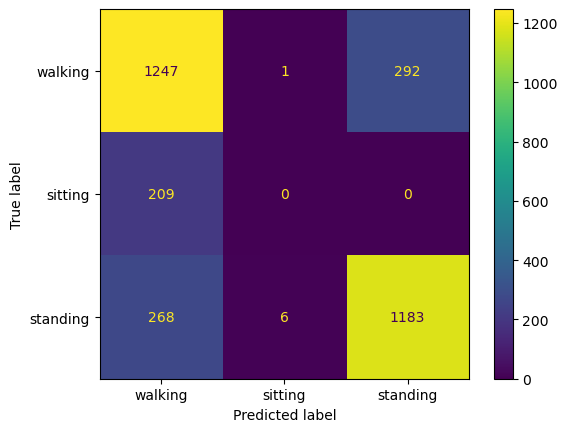

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
scaler=RobustScaler()
pipeline = make_pipeline(scaler, clf)
pipeline.fit(train.drop(columns=["activity"]),train.activity)
cm = confusion_matrix(test.activity, pipeline.predict(test.drop(columns=["activity"])))
ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=train.activity.unique()).plot()

In [21]:
from sklearn import tree

if( isinstance(clf,DecisionTreeClassifier) ): 
    tree.plot_tree(clf)

In [22]:
%pip install m2cgen

Note: you may need to restart the kernel to use updated packages.


In [23]:
import m2cgen as m2c
code = m2c.export_to_javascript(clf)


In [24]:
pipeline.feature_names_in_

array(['alpha__sum__w=1s', 'alpha__median__w=1s', 'alpha__mean__w=1s',
       'alpha__length__w=1s', 'alpha__std_dev__w=1s', 'alpha__var__w=1s',
       'alpha__root_mean_square__w=1s', 'alpha__max__w=1s',
       'alpha__abs_max__w=1s', 'alpha__min__w=1s', 'beta__sum__w=1s',
       'beta__median__w=1s', 'beta__mean__w=1s', 'beta__length__w=1s',
       'beta__std_dev__w=1s', 'beta__var__w=1s',
       'beta__root_mean_square__w=1s', 'beta__max__w=1s',
       'beta__abs_max__w=1s', 'beta__min__w=1s', 'gamma__sum__w=1s',
       'gamma__median__w=1s', 'gamma__mean__w=1s', 'gamma__length__w=1s',
       'gamma__std_dev__w=1s', 'gamma__var__w=1s',
       'gamma__root_mean_square__w=1s', 'gamma__max__w=1s',
       'gamma__abs_max__w=1s', 'gamma__min__w=1s'], dtype=object)

In [25]:
import json
scaler_str=json.dumps(
    {
        "scale": list(scaler.scale_),
        "center": list(scaler.center_),
        "name": type(scaler).__name__
    })
print(scaler_str)

{"scale": [15991.11393737793, 334.0599994659424, 326.93214988708496, 18.0, 6.263924658298492, 40.18094332970213, 327.2997045516968, 343.2225093841553, 343.2225093841553, 324.8499927520752, 823.8525314331055, 14.047500848770142, 13.217953562736511, 18.0, 2.8270509243011475, 8.450372992781922, 12.206010341644287, 14.499999046325684, 14.399999618530273, 16.379999458789825, 356.83997535705566, 8.275000095367432, 8.273346364498138, 18.0, 2.6020041089504957, 7.291431987890974, 6.9354153871536255, 10.420000314712524, 9.520000219345093, 7.400000192224979], "center": [3558.9498291015625, 81.44999694824219, 89.91036605834961, 60.0, 0.7842418849468231, 0.6150353252887726, 92.0, 92.85000228881836, 92.85000228881836, 25.8100004196167, 599.0, 11.822499752044678, 11.935165882110596, 60.0, 0.3566865622997284, 0.12722530215978622, 13.685166835784912, 15.78499984741211, 16.739999771118164, 9.600000381469727, -26.340003967285156, -0.4399999976158142, -0.44150006771087646, 60.0, 0.5153481066226959, 0.2655

In [26]:
#
js=f"""{code}

const classifier =
{{ 
 inputs: {json.dumps(ts_cols)} ,
 classes: {json.dumps(list(clf.classes_))} ,
 window: {0-window_ms},
 score: score , 
 scale: {scaler_str}
}}
;

module.exports = classifier;"""

with open(f"data_snapshot/{sensor}_model.mjs", "w") as file:
    file.write(js)